In [34]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from PIL import Image
import os
import re
import numpy as np
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
kids_puzzles_url = 'https://www.trefl.com/puzzle/dla-dzieci?product_list_limit=all'
adults_puzzles_url = 'https://www.trefl.com/puzzle/dla-doroslych?product_list_limit=all'

In [2]:
def get_links(content):
    soup = BeautifulSoup(content, 'html.parser')
    puzzles_list = soup.find('body')
    puzzles_list_items = puzzles_list.find('ol')
    list_items = puzzles_list_items.find_all('li')
    links = []

    for puzzles in list_items:
        a = puzzles.select_one('a')
        if 'href' in a.attrs:
            link_url = a.get('href')
        links.append(link_url)
    return links

In [3]:
def get_list_of_images_and_age_categories(links):
    excluded_keywords = ['panoramiczne', 'drewniane', 'Megabox']
    image_and_category_dict = {}
    invalid_links = []
    if len(image_and_category_dict) / 50 == 0:
                    print(f'Dict have {len(image_and_category_dict)} items.')
    for link in links:
        response = requests.get(link)
        html_content = response.text
        soup = BeautifulSoup(html_content, "html.parser")

        try:
            keywords = soup.find('meta', attrs={'name': 'keywords'})['content']
        except Exception as e:
            print(f'{e} in link: {link}')
        else:
            if any([keyword in keywords for keyword in excluded_keywords]):
                continue
        
            elements = soup.find_all('div', class_ = 'product-content__img')
            category = soup.find_all('div', class_ = 'c-product-attributes')
            years = BeautifulSoup(str(category[0])).div   
            if len(category) > 1:
                years = BeautifulSoup(str(category[1])).div           
            tag = BeautifulSoup(str(elements[0])).div
            try:
                tag_content = tag.img['src']
                years_content =  re.split(r"([0-9]+)", years.img['src'])[-2]
            except Exception as e:
                invalid_links.append(link)
                print(f'{e} in link: {link}')
            else:
                image_and_category_dict[tag_content] = years_content
    return image_and_category_dict, invalid_links


In [72]:
first_batch_of_links = get_links((requests.get(kids_puzzles_url)).text)
second_batch_of_links = get_links((requests.get(adults_puzzles_url)).text)

In [97]:
print(len(first_batch_of_links))
print(len(second_batch_of_links))
all_links = first_batch_of_links + second_batch_of_links
print(len(all_links))

332
351
683


In [98]:
image_and_category_dict, bad_links = get_list_of_images_and_age_categories(all_links)
img_response = requests.get(list(image_and_category_dict.keys())[0], stream=True)
img = Image.open(img_response.raw)
img.show()

Dict have 0 items.
'NoneType' object is not subscriptable in link: https://www.trefl.com/w-swiecie-transformers-23024
'NoneType' object is not subscriptable in link: https://www.trefl.com/urocze-bobaski-31414
'src' in link: https://www.trefl.com/sorter-kolorow-93162
'NoneType' object is not subscriptable in link: https://www.trefl.com/treflikowy-dzien-93166
'NoneType' object is not subscriptable in link: https://www.trefl.com/farma-44000
'NoneType' object is not subscriptable in link: https://www.trefl.com/zabawny-swiat-binga-93165
'NoneType' object is not subscriptable in link: https://www.trefl.com/zabawy-peppy-93164
'src' in link: https://www.trefl.com/rybka-minimini-36125
'NoneType' object is not subscriptable in link: https://www.trefl.com/bohaterski-spider-man-34384
'NoneType' object is not subscriptable in link: https://www.trefl.com/niezwyciezeni-avengersi-17357
'NoneType' object is not subscriptable in link: https://www.trefl.com/minionki-w-akcji-13264
'NoneType' object is not

In [99]:
len(image_and_category_dict)

484

In [100]:
len(bad_links)

38

In [101]:
for key, value in image_and_category_dict.items():
    if not os.path.exists(value):
        os.makedirs(value)
    response = requests.get(key)
    image_name = f"{key.split('/')[-1]}.png"
    image_path = os.path.join(value, image_name)
    image = response.content
    with open (image_path, 'wb') as file:
        file.write(image)

### Model

In [26]:
main_path = f'{os.getcwd()}\images'
image_size = (500, 500)

image_generator = ImageDataGenerator(
    rescale = 1.0 / 255.0,
    validation_split = 0.2
)

In [27]:
X_train = image_generator.flow_from_directory(
    directory= main_path,
    target_size= image_size,
    batch_size= 16,
    subset= 'training'
)

Found 386 images belonging to 11 classes.


In [28]:
X_val = image_generator.flow_from_directory(
    directory= main_path,
    target_size= image_size,
    batch_size= 16,
    subset= 'validation'
)

Found 92 images belonging to 11 classes.


In [30]:
model = keras.models.Sequential([
    keras.layers.Conv2D(16, (3, 3), activation= 'relu', input_shape = (500, 500, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation= 'relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(11, activation= 'softmax')
])

In [31]:
model.compile(optimizer= 'adam',
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])

In [32]:
custom_model_history = model.fit(X_train, epochs= 10, validation_data= X_val)

Epoch 1/10


c:\Users\kzadk\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


25/25 [==============================] - 16s 601ms/step - loss: 4.3863 - accuracy: 0.2902 - val_loss: 1.9289 - val_accuracy: 0.3152
Epoch 2/10
25/25 [==============================] - 15s 608ms/step - loss: 1.5631 - accuracy: 0.5155 - val_loss: 1.5635 - val_accuracy: 0.5326
Epoch 3/10
25/25 [==============================] - 15s 595ms/step - loss: 1.0297 - accuracy: 0.6632 - val_loss: 1.5975 - val_accuracy: 0.4457
Epoch 4/10
25/25 [==============================] - 15s 594ms/step - loss: 0.5149 - accuracy: 0.8420 - val_loss: 1.7739 - val_accuracy: 0.4457
Epoch 5/10
25/25 [==============================] - 15s 605ms/step - loss: 0.1459 - accuracy: 0.9767 - val_loss: 2.3623 - val_accuracy: 0.4674
Epoch 6/10
25/25 [==============================] - 18s 711ms/step - loss: 0.0227 - accuracy: 0.9974 - val_loss: 2.1169 - val_accuracy: 0.4457
Epoch 7/10
25/25 [==============================] - 15s 607ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 2.5767 - val_accuracy: 0.5000
Epoch 8/10

### Pretrained ResNet50 model


In [24]:
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input

In [33]:
resnet_image_generator = ImageDataGenerator(
    preprocessing_function= preprocess_input,
    validation_split= 0.2
)

base_model = ResNet50(weights= 'imagenet', include_top = False, input_shape= (500, 500, 3))

for layer in base_model.layers:
    layer.trainable = False

flatten_layer = keras.layers.Flatten()(base_model.output)
dense_layer = keras.layers.Dense(128, activation = 'relu')(flatten_layer)
output_layer = keras.layers.Dense(11, activation= 'softmax')(dense_layer)

resnet_model = keras.models.Model(inputs = base_model.input, outputs = output_layer)

resnet_model.compile(optimizer= 'adam',
                     loss = 'categorical_crossentropy',
                     metrics= ['accuracy'])

resnet_model.fit(X_train, epochs= 5, validation_data= X_val)

for layer in model.layers:
    layer.trainable = True

resnet_model_history = model.fit(X_train, epochs= 10, validation_data= X_val)

Epoch 1/5
25/25 [==============================] - 86s 3s/step - loss: 133.0237 - accuracy: 0.1865 - val_loss: 52.3543 - val_accuracy: 0.2391
Epoch 2/5
25/25 [==============================] - 86s 4s/step - loss: 27.6386 - accuracy: 0.2720 - val_loss: 20.7950 - val_accuracy: 0.2717
Epoch 3/5
25/25 [==============================] - 47s 2s/step - loss: 11.7093 - accuracy: 0.3653 - val_loss: 9.4756 - val_accuracy: 0.4674
Epoch 4/5
25/25 [==============================] - 48s 2s/step - loss: 8.5914 - accuracy: 0.4119 - val_loss: 12.7231 - val_accuracy: 0.4457
Epoch 5/5
25/25 [==============================] - 48s 2s/step - loss: 5.3119 - accuracy: 0.5181 - val_loss: 12.0228 - val_accuracy: 0.2826
Epoch 1/10
25/25 [==============================] - 16s 620ms/step - loss: 2.7454e-04 - accuracy: 1.0000 - val_loss: 2.9558 - val_accuracy: 0.4891
Epoch 2/10
25/25 [==============================] - 16s 624ms/step - loss: 2.3150e-04 - accuracy: 1.0000 - val_loss: 2.9461 - val_accuracy: 0.4891
Epo

In [35]:
def plot_history(history):
  #Plot the Loss Curves
  plt.figure(figsize=[8,6])
  plt.plot(history.history['loss'],'r',linewidth=3.0)
  plt.plot(history.history['val_loss'],'b',linewidth=3.0)
  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)

  #Plot the Accuracy Curves
  plt.figure(figsize=[8,6]) 
  plt.plot(history.history['accuracy'], 'r', linewidth=3.0) 

  plt.plot(history.history['val_accuracy'], 'b',linewidth=3.0) 
  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18) 
  plt.xlabel('Epochs ',fontsize=16) 
  plt.ylabel('Accuracy',fontsize=16) 
  plt.title('Accuracy Curves',fontsize=16)

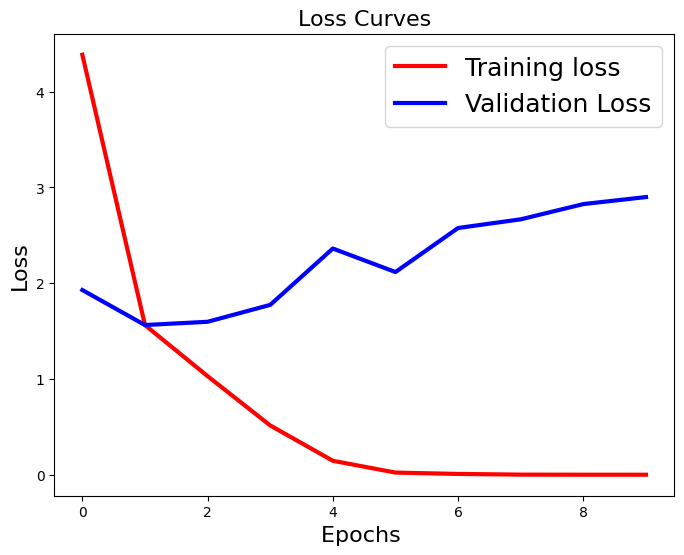

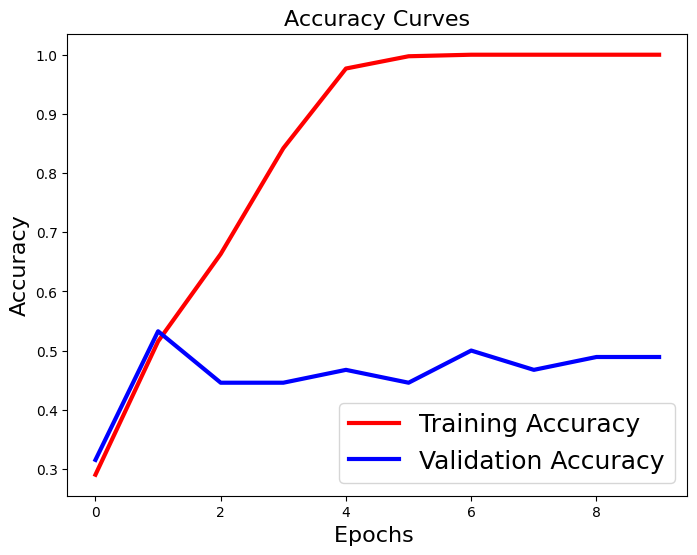

In [36]:
plot_history(custom_model_history)

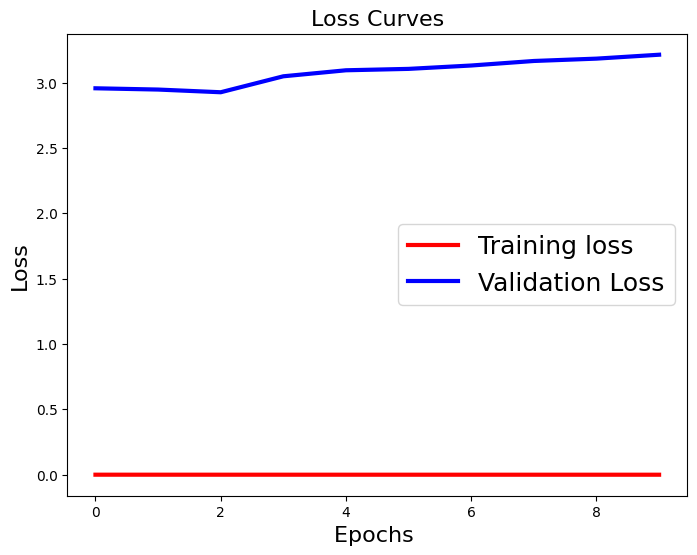

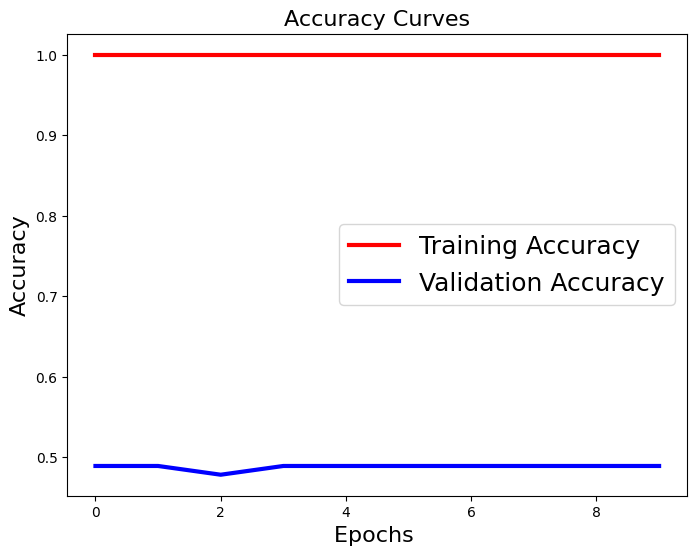

In [37]:
plot_history(resnet_reg_model_history)

#### Same models but with regression

##### Custom model

In [42]:
reg_model = keras.models.Sequential([
    keras.layers.Conv2D(16, (3, 3), activation= 'relu', input_shape = (500, 500, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation= 'relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1)
])

reg_model.compile(optimizer= 'adam',
              loss= 'mean_squared_error',
              metrics= ['mean_absolute_error'])

custom_reg_model_history = model.fit(X_train, epochs= 10, validation_data= X_val)

Epoch 1/10


c:\Users\kzadk\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


25/25 [==============================] - 16s 624ms/step - loss: 5.6476e-05 - accuracy: 1.0000 - val_loss: 3.3457 - val_accuracy: 0.4891
Epoch 2/10
25/25 [==============================] - 16s 634ms/step - loss: 5.3362e-05 - accuracy: 1.0000 - val_loss: 3.3770 - val_accuracy: 0.4891
Epoch 3/10
25/25 [==============================] - 16s 630ms/step - loss: 5.0181e-05 - accuracy: 1.0000 - val_loss: 3.3693 - val_accuracy: 0.4891
Epoch 4/10
25/25 [==============================] - 16s 634ms/step - loss: 4.7140e-05 - accuracy: 1.0000 - val_loss: 3.3774 - val_accuracy: 0.4783
Epoch 5/10
25/25 [==============================] - 16s 635ms/step - loss: 4.4493e-05 - accuracy: 1.0000 - val_loss: 3.4113 - val_accuracy: 0.4891
Epoch 6/10
25/25 [==============================] - 16s 635ms/step - loss: 4.2141e-05 - accuracy: 1.0000 - val_loss: 3.4338 - val_accuracy: 0.4891
Epoch 7/10
25/25 [==============================] - 16s 646ms/step - loss: 4.0052e-05 - accuracy: 1.0000 - val_loss: 3.4439 - val

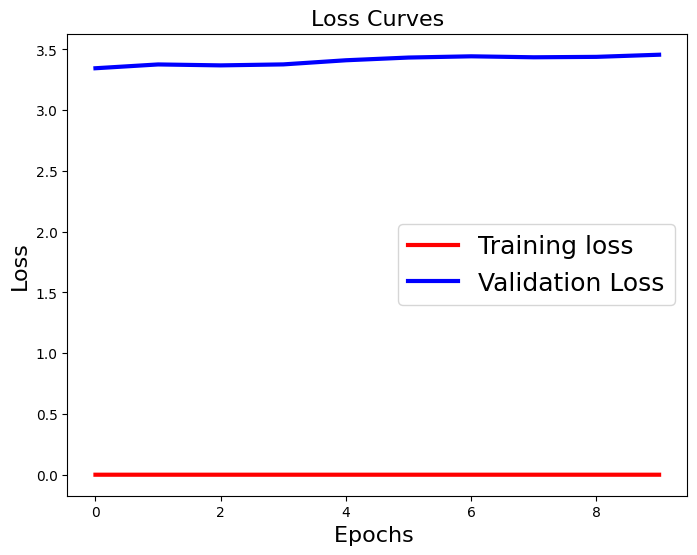

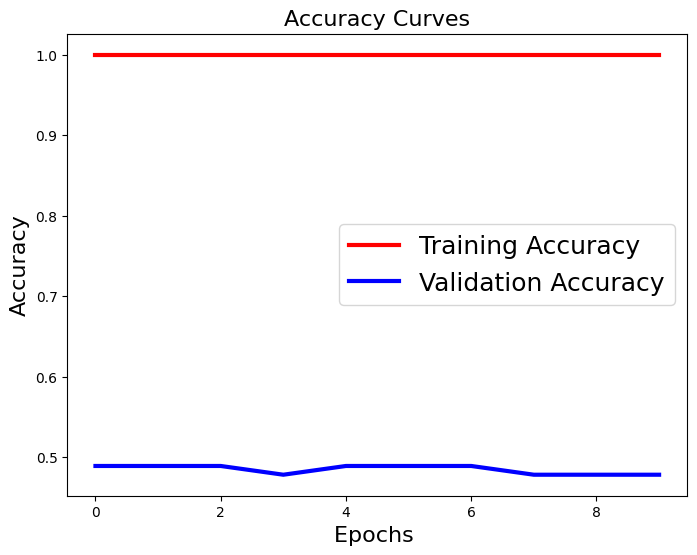

In [43]:
plot_history(custom_reg_model_history)

#### Pretrained model

In [47]:
resnet_image_generator = ImageDataGenerator(
    preprocessing_function= preprocess_input,
    validation_split= 0.2
)

base_model = ResNet50(weights= 'imagenet', include_top = False, input_shape= (500, 500, 3))

for layer in base_model.layers:
    layer.trainable = False

global_avg_pooling_layer = keras.layers.GlobalAveragePooling2D()(base_model.output)
output_layer = keras.layers.Dense(1)(global_avg_pooling_layer) 

resnet_reg_model = keras.models.Model(inputs = base_model.input, outputs = output_layer)

resnet_reg_model.compile(optimizer= 'adam',
                     loss = 'mean_squared_error',
                     metrics= ['mean_absolute_error'])

resnet_reg_model.fit(X_train, epochs= 5, validation_data= X_val)

for layer in model.layers:
    layer.trainable = True

resnet_reg_model_history = model.fit(X_train, epochs= 10, validation_data= X_val)

Epoch 1/5


c:\Users\kzadk\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


25/25 [==============================] - 43s 2s/step - loss: 0.2008 - mean_absolute_error: 0.3337 - val_loss: 0.0998 - val_mean_absolute_error: 0.2535
Epoch 2/5
25/25 [==============================] - 45s 2s/step - loss: 0.0941 - mean_absolute_error: 0.1955 - val_loss: 0.0872 - val_mean_absolute_error: 0.1819
Epoch 3/5
25/25 [==============================] - 50s 2s/step - loss: 0.0868 - mean_absolute_error: 0.1671 - val_loss: 0.0862 - val_mean_absolute_error: 0.1825
Epoch 4/5
25/25 [==============================] - 45s 2s/step - loss: 0.0857 - mean_absolute_error: 0.1695 - val_loss: 0.0867 - val_mean_absolute_error: 0.1387
Epoch 5/5
25/25 [==============================] - 77s 3s/step - loss: 0.0854 - mean_absolute_error: 0.1679 - val_loss: 0.0864 - val_mean_absolute_error: 0.1376
Epoch 1/10
25/25 [==============================] - 26s 1s/step - loss: 2.1965e-05 - accuracy: 1.0000 - val_loss: 3.5407 - val_accuracy: 0.4674
Epoch 2/10
25/25 [==============================] - 25s 1s/st

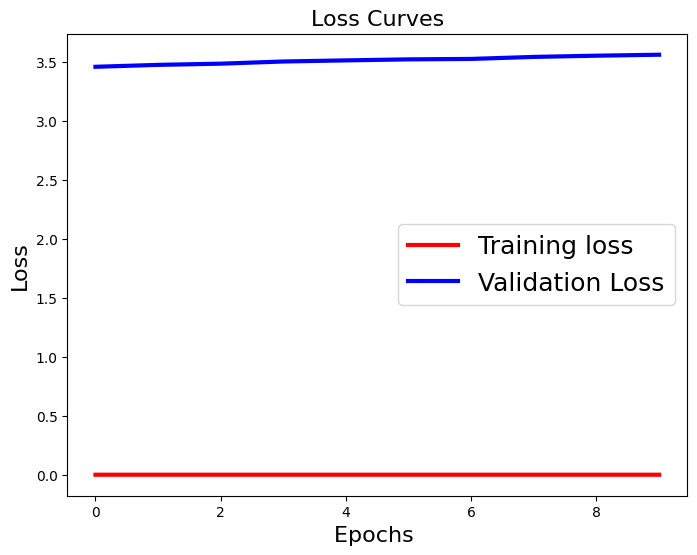

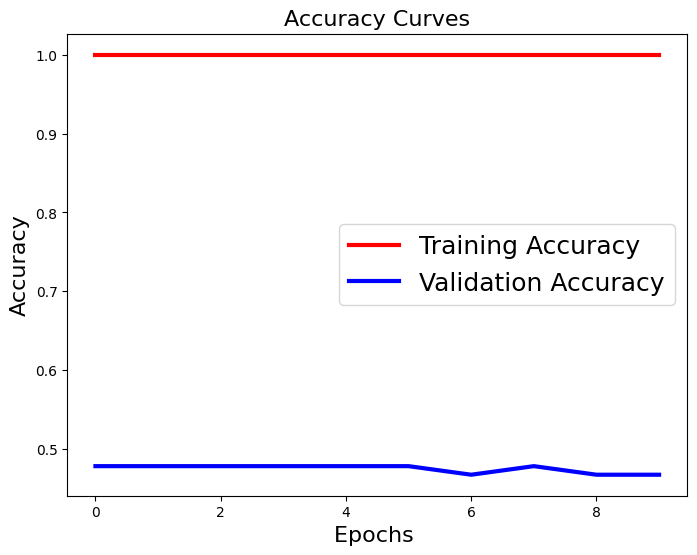

In [45]:
plot_history(resnet_reg_model_history)

In [48]:
# model.save(fr'{os.getcwd()}\models\Custom_classification_model')
# resnet_model.save(fr'{os.getcwd()}\models\Resnet_classification_model')
# reg_model.save(fr'{os.getcwd()}\models\Custom_regression_model')
# resnet_reg_model.save(fr'{os.getcwd()}\models\Resnet_regression_model')

INFO:tensorflow:Assets written to: d:\DataScienceProjects\Jigsaw-Puzzle-Difficulty\models\Resnet_regression_model\assets


INFO:tensorflow:Assets written to: d:\DataScienceProjects\Jigsaw-Puzzle-Difficulty\models\Resnet_regression_model\assets
